In [1]:
import json
import logging
import sys

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from collections import defaultdict, Counter
from copy import deepcopy

from typing import List

from prettyprinter import pprint
from gcdf1.analysis import (
    analyse_info_expression_patterns,
    analyse_hierarchical_context_feature,
    get_goal_constraints_by_type
)
from gcdf1.utils.data import split_iterator
from gcdf1.utils.print import print_dialogue_outline
from gcdf1.utils.utils import (
    count_nested_dict_values,
    default_to_regular,
    nested_defaultdict,
    safeget
)
from gcdf1.utils.visualisation import plot_stacked_bar

# Introduction

This notebook shows how to reproduce the results concerned with the I-GCDF1 metric in Section 4 of the [GCDF1: A Goal- and Context- Driven F-Score for Evaluating User
Models](https://aclanthology.org/2021.eancs-1.2.pdf).

# Load data

First, we load the data that we analysed in the paper. The ``../models/convlab_baselines/test`` directory contains the
conversations generated by the agents described in Section 4.1 of the paper, when conditioned
on the MultiWOZ 2.1 dataset test goals.

In [3]:
SPLIT = 'test'  # data is only available for the test split
BASELINE_PATH_PREFIX = f"../models/convlab_baselines/{SPLIT}"
BASELINE_DATA_PATH = "../models/convlab_baselines"
EVAL_CONFIG_PATH = '../configs/multiwoz_user_evaluator.yaml'
CANONICAL_MAP_PATH = "../resources/canonical_map.json"

In [4]:
with open(f"{BASELINE_PATH_PREFIX}/baseline.json", "r") as f:
    baseline_metadata = json.load(f)["metadata"]["igcd_f1"]
    
with open(CANONICAL_MAP_PATH, "r") as f:
    CANONICAL_MAP = json.load(f)
    
with open(f"{BASELINE_PATH_PREFIX}/baseline.json", "r") as f:
    dial_counts = json.load(f)["metadata"]['counts']["igcd_f1"]
    dial_counts.pop("combined")

## Analyse constraints repetitions

We now look at the reasons why the user repeats constraints. This information is stored in the
`multiple_constraint_informs` field of the `igcd_f1` `metadata` in the evaluator output.

In [5]:
rep_constr =  {
    'baseline':baseline_metadata["multiple_constraint_informs"]
}

The evaluator contains some fields that are used for validation of some of the behaviours (e.g.,
`nooffer_validation_failure`, `nobook_validation_failure`) and the `wrong_taxi_annotations` field which is used to store
dialogues in the corpus where repetitions occur due to erroneous annotations in the taxi domain. We exclude these fields
from our analysis.

In [6]:
def remove_keys(d: dict, keys_list: List[str]):

    for key in keys_list:
        try:
            d.pop(key)
        except KeyError:
            continue

noise_keys = ["nooffer_validation_failure","nobook_validation_failure", "wrong_taxi_annotations"]
remove_keys(rep_constr['baseline'], noise_keys)

The evaluator tries to ascribe each constraint repetition to a behaviour. The behaviours are the keys
on the `rep_constr['baseline']` dictionary. We can analyse this output using the
`analyse_hierarchical_context_feature` function as shown below. Head over to the `gcdf1.analysis` module for detailed
documentation of this function's output.

For convenience, we shorten the names of the behaviour names in the evaluator output.

In [7]:
sys_keys_map = {
    'elicited_by_booking_failure': 'nobooking',
    'elicited_by_no_offers': 'nooffer',
    'elicited_by_sys_question': 'sys_q',
    'failed_sys_nlu': 'nlu_fail',
}

usr_keys_map = {
    'confirmed_choice_params': 'confirms_choice',
    'repeated_when_answering_request': 'rep_on_answer',
    'repeated_while_requesting_info': 'rep_on_req',
    'repeated_while_booking': 'booking_rep',
    'switched_between_domains': 'domain_switch'
}

keys_map = deepcopy(sys_keys_map)
keys_map.update(usr_keys_map)


In [8]:
rep_data = {
    'baseline': analyse_hierarchical_context_feature(
        rep_constr['baseline'], 
        ["match_key", "domain"], 
        new_behaviour_names=keys_map)
}
rep_count = {
    'baseline': count_nested_dict_values(rep_data['baseline'])
}

We can use one of the plotting functions in `gcdf1.utils.visualisation` to visualise
our data. 

In [9]:
plot_format = {
    'colors': [],
    'stack_order': [],  # must match data dict keys
    'legend': {'fontsize': 'x-large', 'ncol': 3, 'loc': 'upper center'},  # ax.legend API
    'subplot': {'figsize':  (9.77, 5.5)},  # plt.subplot API
    'width': 0.75,
    'ylim': {"bottom": -2, "top": 3.25},
    'xlim': {"left": 0, "right": 50},
    "xlabel": {"xlabel": "# dialogues", "size": "xx-large"},
    "ylabel": {"ylabel": "Domain", "size": "xx-large"},
    'tick_params':{
    'x': {'labelsize': 'xx-large'},  # ax.tick_params  API
    'y': {'labelsize': 'xx-large'}},
    'orientation': 'horizontal',
    'title': {'label':""}
}


In [10]:
plot_format['colors'] = sns.color_palette("Set2", n_colors=len(rep_count['baseline'].keys()))
plot_format['stack_order'] = sorted(list(rep_count['baseline'].keys()))
plot_format['ylim'] = {"bottom": -2, "top": 7.25}
plot_format['subplot']['figsize'] = (10.625, 6.25)  # plt.subplot API
plot_format['xlim'] = {'right': 300}

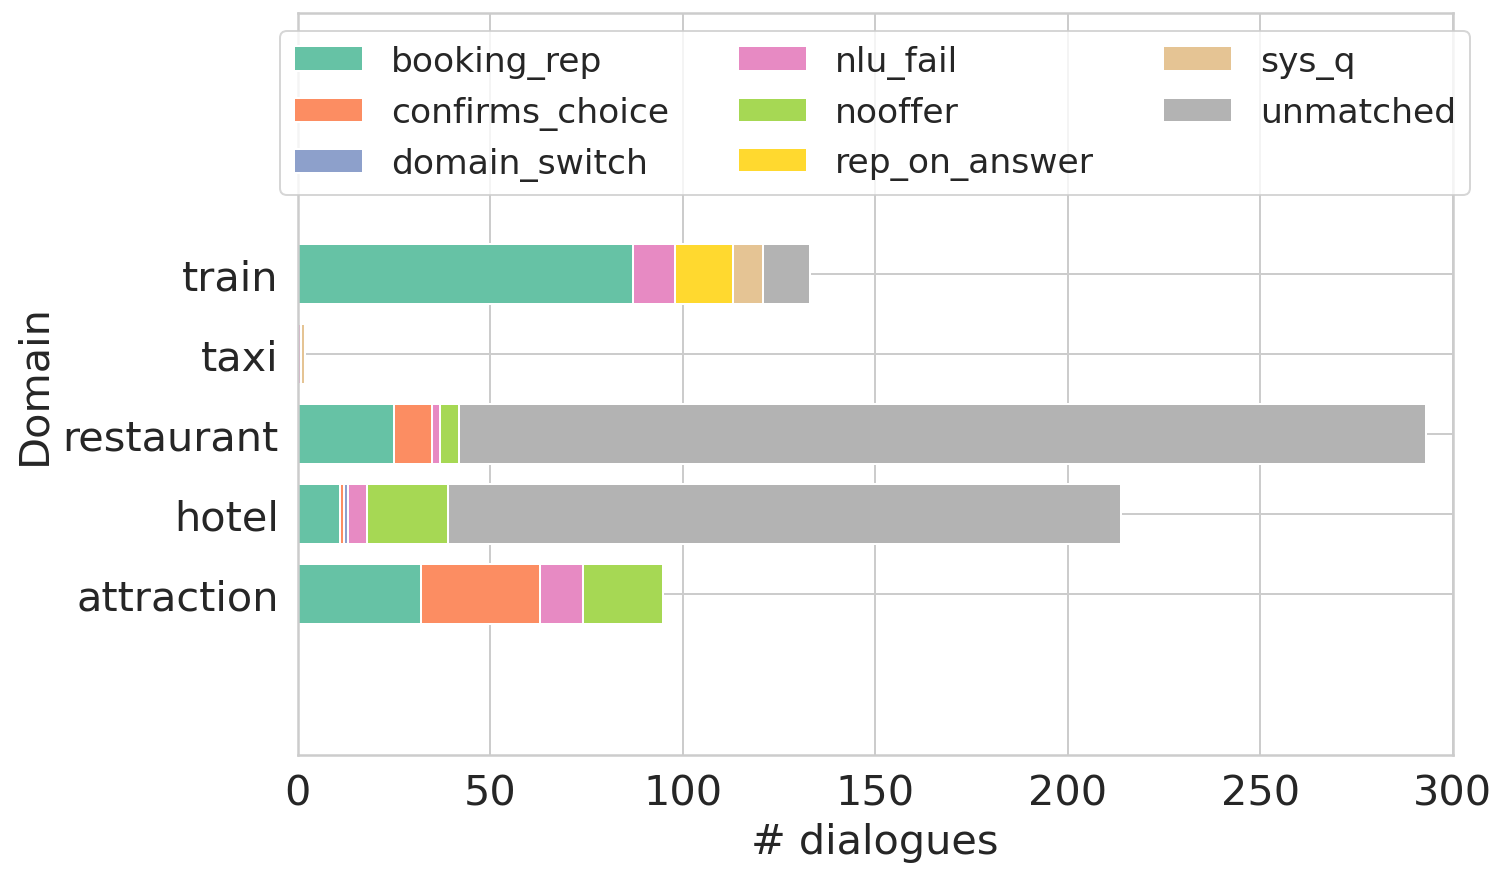

In [11]:
ax, fig = plot_stacked_bar(
    rep_count['baseline'], plot_format
)
plt.tight_layout()

Below we show how to conduct a detailed analysis of our dialogues with repetead constraints.
This is done by passing the `store_dial_id=True` to `analyse_hierarchical_context_feature` to store the
dialogue IDs. The `extract_slots` function is then used to map domain names to behaviours that let to repetition. 
The data for each bevaviour is a dictionary with `{domain_name: [slot_name, ...]}` format. 

In [12]:
def extract_slots(data_dict, keep_reasons = True):

    depth = 2 if keep_reasons else 1
    slots_dict = nested_defaultdict(list, depth=depth)
    for reason in data_dict:
        for domain in data_dict[reason]:
            for slot in data_dict[reason][domain]:
                if keep_reasons:
                    slots_dict[reason][domain].append(slot)
                else:
                    slots_dict[domain].append(slot)

    return default_to_regular(slots_dict)

In [13]:
keys = ["match_key", "domain", "slot"]
rep_data_slot = {
    'baseline': analyse_hierarchical_context_feature(
        rep_constr['baseline'], 
        keys, 
        new_behaviour_names=keys_map,
        store_dial_id=True)
}
repeated_slots = {
    'baseline': extract_slots(rep_data_slot['baseline'], keep_reasons=True)
}

We can now extract the IDs of the dialogues where a certain behaviour leading to constraint repetition was detected. We
can easily perform this analysis for each domain-slot combination as shown below.

In [14]:
behaviour = 'unmatched'
domain = 'hotel'
slot = 'type'
dialogues = rep_data_slot['baseline'][behaviour][domain][slot]

It is thus easy to obtain statistics about repetitions of a slot in any given domain:

In [15]:
slt = ['parking', 'type']
domain, behaviour = 'hotel', 'unmatched'
for sl in slt:
    print(len(set(rep_data_slot['baseline'][behaviour][domain][sl])))

1
6


We can query the generated conversations to retrieve the dialogues and understand the system and user behaviour in depth 
as a result.

In [16]:
data_path = BASELINE_DATA_PATH
for _, dial in split_iterator(
    "test",
    data_pckg_or_path=data_path,
):
    dial_id = dial['dialogue_id']
    if dial_id not in dialogues:
        continue
    print(dial_id)
    print()
    print()
    print(pprint(dial["goal"]))
    print()
    print_dialogue_outline(dial, text=True)

PMUL2869.json


{
    'attraction': {
        'fail_info': {'area': 'west', 'type': 'mutliple sports'},
        'info': {'area': 'west', 'type': 'entertainment'},
        'reqt': {'address': '?'}
    },
    'hotel': {
        'info': {
            'internet': 'yes',
            'pricerange': 'moderate',
            'type': 'guesthouse'
        },
        'reqt': {
            'address': '?',
            'area': '?',
            'phone': '?'
        }
    }
}
None

Turn: 0:USER I also need a hotel. I would prefer something that is in the moderate price range . Do you have one that is a guesthouse ? It should have free wifi .
hotel-inform<<<pricerange===moderate
hotel-inform<<<type===guesthouse
hotel-inform<<<internet===yes

###############  NLU  ###############

Turn: 1:SYSTEM How about hamilton lodge ? It 's located in the north . We have 14 such places .
hotel-inform<<<choice===14
hotel-recommend<<<name===hamilton lodge
hotel-recommend<<<area===north

###############  NLU  ###########

PMUL4840.json


{
    'hotel': {
        'info': {
            'area': 'east',
            'internet': 'yes',
            'stars': '4',
            'type': 'guesthouse'
        },
        'reqt': {
            'address': '?',
            'parking': '?',
            'phone': '?'
        }
    },
    'restaurant': {
        'book': {
            'day': 'thursday',
            'people': '5',
            'time': '13:30'
        },
        'booked': '?',
        'info': {'name': 'golden house'}
    }
}
None

Turn: 0:USER I ' m looking for a hotel . I ' m looking for a guesthouse type place to stay . It should have free wifi . I would prefer the hotel be in the east .
hotel-inform<<<type===guesthouse
hotel-inform<<<internet===yes
hotel-inform<<<area===east

###############  NLU  ###############

Turn: 1:SYSTEM I would suggest autumn house. There are 6 of those .
hotel-inform<<<choice===6
hotel-recommend<<<name===autumn house

###############  NLU  ###############
hotel-inform<<<internet===ye

PMUL4155.json


{
    'hotel': {
        'info': {
            'area': 'north',
            'stars': '4',
            'type': 'guesthouse'
        },
        'reqt': {
            'address': '?',
            'internet': '?',
            'pricerange': '?'
        }
    },
    'train': {
        'book': {'people': '8'},
        'booked': '?',
        'info': {
            'arriveBy': '15:30',
            'day': 'wednesday',
            'departure': 'stansted airport',
            'destination': 'cambridge'
        }
    }
}
None

Turn: 0:USER I also need a hotel. I ' m looking for a place that is at least a 4 star location ? Could you help me with a finding a guesthouse ? I ' m looking for a place to stay in the north .
hotel-inform<<<stars===4
hotel-inform<<<type===guesthouse
hotel-inform<<<area===north

###############  NLU  ###############

Turn: 1:SYSTEM Everyone seems to enjoy the acorn guest house . I have 8 different options for you !.
hotel-inform<<<choice===8
hotel-recommend<<<n

## Constraints not in goal

The constraints not in goal feature is stored in the `['metadata']['igcd_f1']` field of the evaluator output in the
`'constraints_not_in_goal_fiel`

In [17]:
constr_not_in_goal = {
    'baseline': baseline_metadata["constraints_not_in_goal"]
}

In [18]:
keys_map = {
    'auto_matched_slot': 'auto_matched',
    'auto_matched_slot_value_pair': 'auto_matched',
    'auto_matched_value': 'auto_matched',
    'elicited_by_booking_acceptance': 'sys_book',
    'elicited_by_booking_failure': 'sys_book',
    'elicited_by_sys_offer': 'sys_offer',
    'elicited_by_sys_question': 'sys_q',
    'elicited_by_recommendation': 'sys_recom',
    'unmatched': 'nomatch',
    'first_turn': 'first_turn_nomatch'
}

Check out what constraints are mapped below

In [19]:
keys = ['match_key', 'domain', 'slot']
not_in_goal_behaviours = {
    'baseline': analyse_hierarchical_context_feature(
        constr_not_in_goal['baseline'],
        keys,
        new_behaviour_names=keys_map,
        store_dial_id=False
)}
not_in_goal_behaviours_dial = {
    'baseline': analyse_hierarchical_context_feature(
        constr_not_in_goal['baseline'], 
        keys, 
        new_behaviour_names=keys_map,
        store_dial_id=True)
}

We can see why the baseline `Convlab2` user provided constraints that are not in the goal by simply printing the keys 
of our analysis' output.

In [20]:
not_in_goal_behaviours['baseline'].keys()

dict_keys(['auto_matched', 'sys_recom', 'sys_offer', 'nomatch'])

It is also easy to obtain statistics for the behaviours that lead to mentioning of constraints not in goal. Here
`auto_matched` refers to a situation when the user generates a constraint of type `slot=dontcare`.

In [21]:
key = 'auto_matched'
domain = 'taxi'
slot = 'leaveat'

store_key = [key, domain, slot]

pprint(Counter(safeget(not_in_goal_behaviours['baseline'], *store_key)))
print()
print(Counter(safeget(not_in_goal_behaviours['baseline'], *store_key)))

collections.Counter({'leaveat===dontcare': 2})

Counter({'leaveat===dontcare': 2})


In [22]:
key = 'nomatch'

for domain in not_in_goal_behaviours['baseline'][key]:
    print(f"######### {domain} ########")
    print("")
    for slot in not_in_goal_behaviours['baseline'][key][domain]:
        print(f"######### {slot} ########")
        store_key = [key, domain, slot]
        pprint(Counter(safeget(not_in_goal_behaviours['baseline'], *store_key)))
        print()

######### restaurant ########

######### notbook ########
collections.Counter({'notbook===none': 12})

######### attraction ########

######### choice ########
collections.Counter({'choice===any': 7})

######### hotel ########

######### notbook ########
collections.Counter({'notbook===none': 7})

######### train ########

######### notbook ########
collections.Counter({'notbook===none': 2})



To see the conversations, we proceed in a manner analogous to our repeated constraints analysis above:

In [23]:
keys = ['match_key', 'domain', 'slot']
not_in_goal_behaviours['baseline'] = analyse_hierarchical_context_feature(
    constr_not_in_goal['baseline'], 
    keys, 
    new_behaviour_names=keys_map, 
    store_dial_id=True
)
not_in_goal_slots = extract_slots(
    not_in_goal_behaviours_dial['baseline'],
    keep_reasons=True
)

In [24]:
not_in_goal_slots

{'auto_matched': {'hotel': ['stars', 'pricerange', 'area', 'name'],
  'train': ['leaveat', 'arriveby', 'people'],
  'attraction': ['name', 'type', 'area'],
  'taxi': ['leaveat']},
 'sys_recom': {'attraction': ['name']},
 'sys_offer': {'hotel': ['name'],
  'restaurant': ['choice', 'name'],
  'train': ['leaveat'],
  'attraction': ['type', 'name', 'choice']},
 'nomatch': {'restaurant': ['notbook'],
  'attraction': ['choice'],
  'hotel': ['notbook'],
  'train': ['notbook']}}

In [25]:
key = 'nomatch'
domain = 'restaurant'
slot = 'notbook'

for _, dial in split_iterator(
    "test",
    data_pckg_or_path=BASELINE_DATA_PATH,
):
    dial_id = dial['dialogue_id']
    if dial_id not in set(not_in_goal_behaviours_dial['baseline'][key][domain][slot]):
        continue
    print(dial_id)
    print(pprint(dial["goal"]))
    print()
    print_dialogue_outline(dial, text=True)

PMUL4125.json
{
    'restaurant': {
        'info': {'name': 'chiquito restaurant bar'},
        'reqt': {'area': '?', 'phone': '?'}
    },
    'train': {
        'info': {
            'arriveBy': '13:45',
            'day': 'sunday',
            'departure': 'cambridge',
            'destination': 'london liverpool street'
        },
        'reqt': {'leaveAt': '?', 'trainID': '?'}
    }
}
None

Turn: 0:USER I need a restaurant to dine at in Cambridge on my upcoming trip . I need info about chiquito restaurant bar restaurant .
restaurant-inform<<<name===chiquito restaurant bar

###############  NLU  ###############

Turn: 1:SYSTEM That is a mexican restaurant . This is a expensive one . Would you like to try chiquito restaurant bar ?
restaurant-inform<<<food===mexican
restaurant-inform<<<name===chiquito restaurant bar
restaurant-inform<<<pricerange===expensive

###############  NLU  ###############
restaurant-inform<<<name===chiquito restaurant bar restaurant


Turn: 2:USER I do not n

SNG0689.json
{
    'restaurant': {
        'info': {'area': 'west', 'food': 'british'},
        'reqt': {
            'address': '?',
            'phone': '?',
            'postcode': '?'
        }
    }
}
None

Turn: 0:USER I need to find information about a certain restaurant , can you help with that ? Do you have british food ? I also would like information on a place to eat in the west .
restaurant-inform<<<food===british
restaurant-inform<<<area===west

###############  NLU  ###############

Turn: 1:SYSTEM I have a place called saint johns chop house , does that sound like something you would enjoy ? The reference number is 00000053 . There are 3 different places that match your description .
restaurant-inform<<<choice===3
restaurant-recommend<<<name===saint johns chop house
restaurant-recommend<<<ref===00000053

###############  NLU  ###############
restaurant-inform<<<food===british
restaurant-inform<<<area===west


Turn: 2:USER I do not need to book.
restaurant-inform<<<notbook

PMUL4636.json
{
    'hotel': {
        'book': {
            'day': 'wednesday',
            'people': '5',
            'stay': '2'
        },
        'booked': '?',
        'info': {
            'internet': 'yes',
            'pricerange': 'moderate',
            'stars': '4'
        }
    },
    'restaurant': {'info': {'name': 'rice boat'}, 'reqt': {'food': '?'}}
}
None

Turn: 0:USER Hello , can you help me find a restaurant for my upcoming trip to Cambridge ? Need a restaurant called rice boat.
restaurant-inform<<<name===rice boat

###############  NLU  ###############

Turn: 1:SYSTEM That is a indian restaurant . It is in the west area . This is a expensive one . Would you like to try rice boat ?
restaurant-inform<<<food===indian
restaurant-inform<<<name===rice boat
restaurant-inform<<<area===west
restaurant-inform<<<pricerange===expensive

###############  NLU  ###############
restaurant-inform<<<name===rice boat


Turn: 2:USER I 'm not looking to make a booking at the moment. I n

Finally, we can visualise the behaviour statistics for our user model.

In [26]:
match_reasons_per_domain = analyse_hierarchical_context_feature(
    constr_not_in_goal['baseline'],
    keys = ['match_key', 'domain'],
    new_behaviour_names=keys_map
)

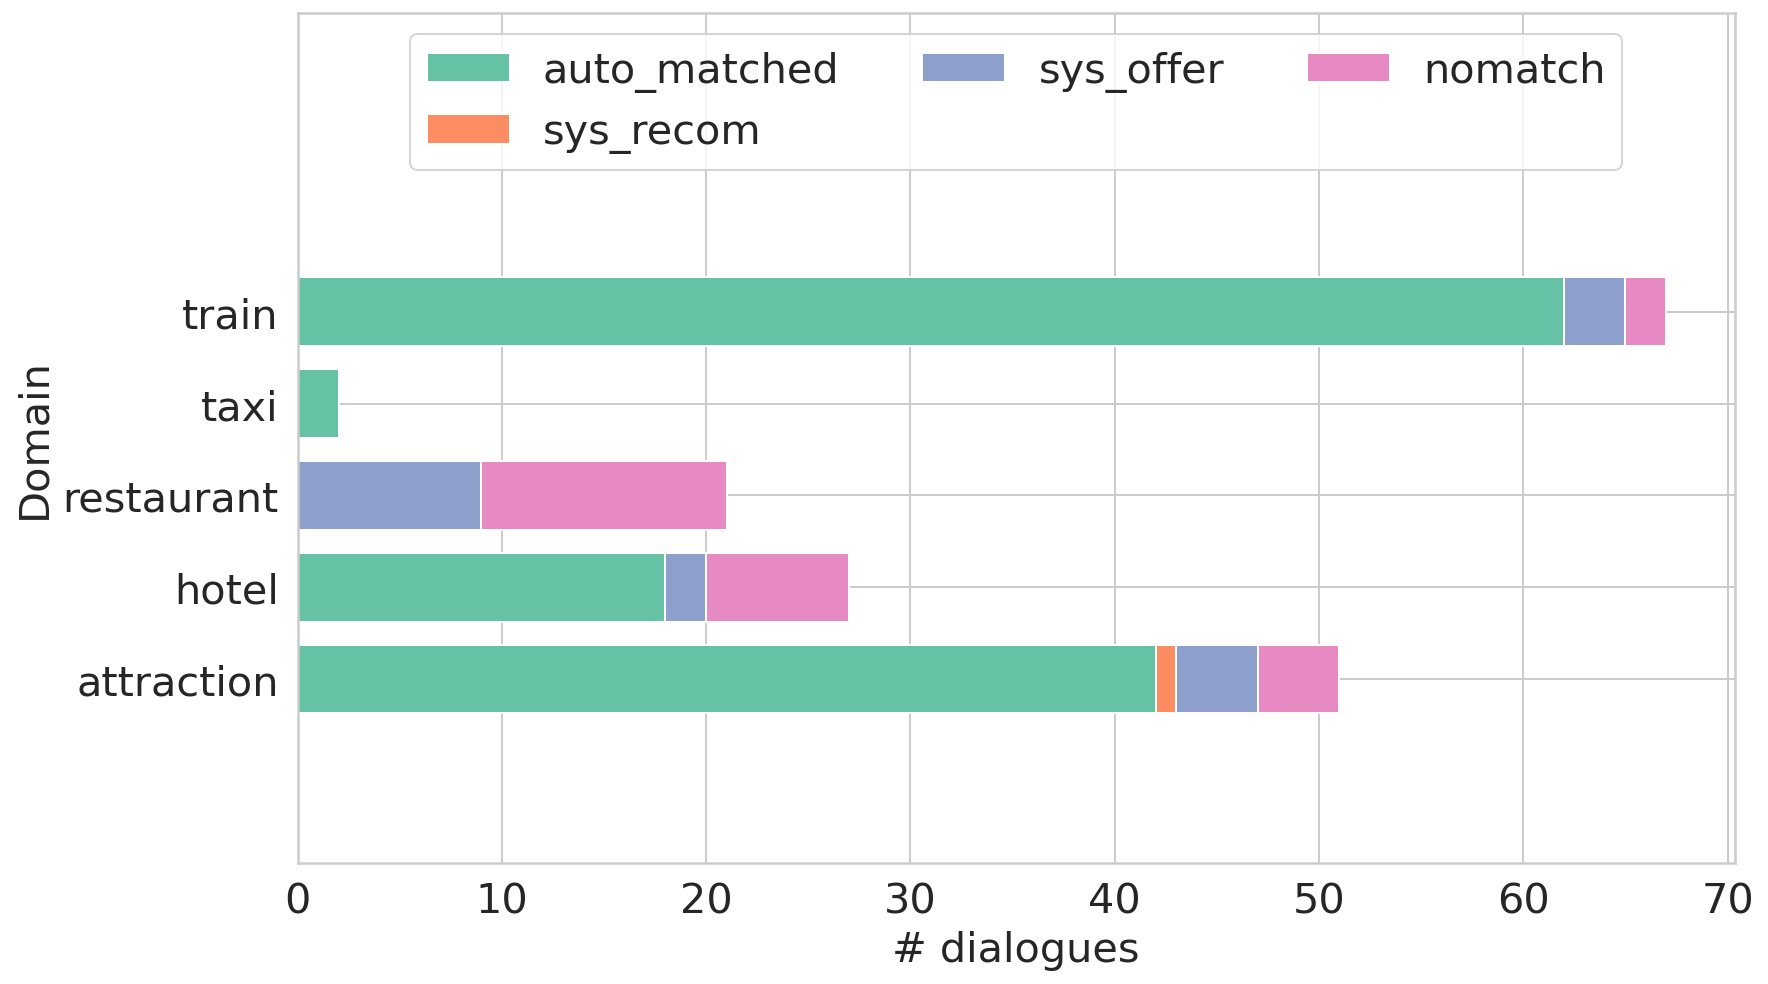

In [27]:
plot_format = {
    'colors': sns.color_palette("Set2", n_colors=len(match_reasons_per_domain.keys())),
    'stack_order': ['auto_matched', 'sys_recom', 'sys_offer', 'nomatch' ],  # must match data dict keys
    'legend': {'fontsize': 'xx-large', 'ncol': 3, 'loc': 'upper center'},  # ax.legend API
    'subplot': {'figsize': (12.4444, 7)},  # plt.subplot API
    'width': 0.75,
    'ylim': {"bottom": -2, "top": 7.25},
#     'xlim': {"left": 0, "right": 100},

    "xlabel": {"xlabel": "# dialogues", "size": "xx-large"},
    "ylabel": {"ylabel": "Domain", "size": "xx-large"},
    'tick_params':{
    'x': {'labelsize': 'xx-large'},  # ax.tick_params  API
    'y': {'labelsize': 'xx-large'}
    },

    'orientation': 'horizontal',
    'title': {'label': ""}
}

ax, fig = plot_stacked_bar(
    count_nested_dict_values(match_reasons_per_domain), plot_format
)
plt.tight_layout()

## Missed domain analysis

The evaluator stores information about domains that are in the goal but not appear in the conversation in the
`['metadata']['igcd_f1']['missed_domain']` field of the evaluator output. Below we count and plot this data:

In [28]:
missed_domain_baseline = baseline_metadata['missed_domain']
missed_domain_dials = defaultdict(list)
for dial_id in missed_domain_baseline:
    for domain in missed_domain_baseline[dial_id]:
        missed_domain_dials[domain].append(dial_id)
missed_domain_counts = count_nested_dict_values(missed_domain_dials)

In [29]:
missed_domain_counts_data = {'missed': missed_domain_counts, 'not_missed': {}}
for domain in missed_domain_counts:
    missed_domain_counts_data['not_missed'][domain] = dial_counts[domain] - missed_domain_counts[domain]

In [30]:
missed_domain_perc = {'missed': {}, 'not_missed': {}}
for key in missed_domain_counts_data:
    for domain in missed_domain_counts_data[key]:
        missed_domain_perc[key][domain] = round(100*missed_domain_counts_data[key][domain]/dial_counts[domain], 2)

In [31]:
missed_domain_perc

{'missed': {'restaurant': 5.95,
  'hotel': 12.18,
  'taxi': 51.79,
  'train': 28.48,
  'attraction': 13.89},
 'not_missed': {'restaurant': 94.05,
  'hotel': 87.82,
  'taxi': 48.21,
  'train': 71.52,
  'attraction': 86.11}}

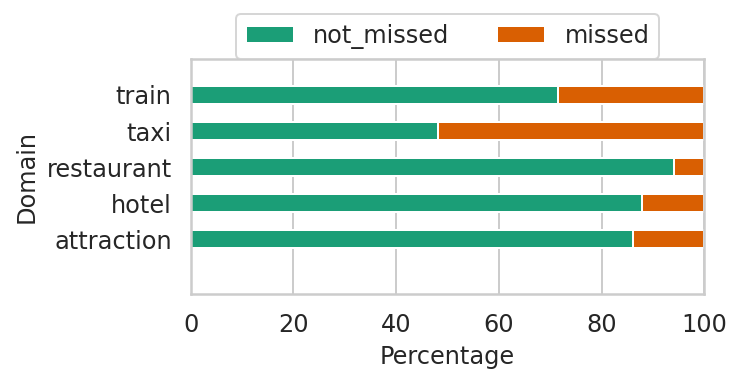

In [32]:
plot_format = {
    'colors': sns.color_palette("Dark2", n_colors=len(missed_domain_perc.keys())),
    'stack_order': sorted(missed_domain_perc.keys(), reverse=True),  # must match data dict keys
    'legend': {'fontsize': 'medium', 'ncol': 2, 'loc': 'upper center', 'bbox_to_anchor': (0.5,1.24)},  # ax.legend API
    'subplot': {'figsize': (5.3333, 3)},  # plt.subplot API
    'width': 1,
    'ylim': {"bottom": -3, "top": 10},
    'xlim': {"left": 0, "right": 100},

    "xlabel": {"xlabel": "Percentage", "size": "medium"},
    "ylabel": {"ylabel": "Domain", "size": "medium"},
    'tick_params':{
        'x': {'labelsize': 'medium'},  # ax.tick_params  API
        'y': {'labelsize': 'medium'}
    },
    
    'orientation': 'horizontal',
    'scale': {'y': 2},
    'title': {'label': ''}
}

ax, fig = plot_stacked_bar(missed_domain_perc, plot_format)
plt.tight_layout()

We can use the printing utility functions to see why certain domains were missed.

In [33]:
domain = 'restaurant'
for _, dial in split_iterator(
    "test",
    data_pckg_or_path=BASELINE_DATA_PATH,
):
    if dial['dialogue_id'] not in set(missed_domain_dials[domain]):
        continue
    print(dial['dialogue_id'])
    print()
    print()
    print(pprint(dial["goal"]))
    print()
    print_dialogue_outline(dial, text=True)

MUL1350.json


{
    'hotel': {
        'book': {
            'day': 'thursday',
            'people': '8',
            'stay': '4'
        },
        'booked': '?',
        'info': {
            'area': 'east',
            'parking': 'yes',
            'pricerange': 'cheap'
        }
    },
    'restaurant': {
        'book': {
            'day': 'thursday',
            'people': '8',
            'time': '12:45'
        },
        'booked': '?',
        'info': {'food': 'indian', 'pricerange': 'cheap'}
    },
    'taxi': {
        'info': {'arriveBy': '12:45'},
        'reqt': {'car type': '?', 'phone': '?'}
    }
}
None

Turn: 0:USER I also need a hotel. Would you be able to help me find a place to stay in the east ? I would prefer something that is in the cheap price range . I 'd like to book one that offers parking please .
hotel-inform<<<area===east
hotel-inform<<<pricerange===cheap
hotel-inform<<<parking===yes

###############  NLU  ###############

Turn: 1:SYSTEM Everyone seems 

PMUL4644.json


{
    'hotel': {
        'book': {
            'day': 'sunday',
            'people': '5',
            'stay': '5'
        },
        'booked': '?',
        'fail_info': {
            'area': 'north',
            'pricerange': 'expensive',
            'type': 'guesthouse'
        },
        'info': {
            'area': 'north',
            'pricerange': 'moderate',
            'type': 'guesthouse'
        }
    },
    'restaurant': {
        'fail_info': {'area': 'north', 'food': 'modern american'},
        'info': {'area': 'north', 'food': 'asian oriental'},
        'reqt': {'postcode': '?', 'pricerange': '?'}
    }
}
None

Turn: 0:USER I need a hotel please . I 'd really prefer a guesthouse . I also need a expensive place to stay . Would you be able to help me find a place to stay in the north ?
hotel-inform<<<type===guesthouse
hotel-inform<<<pricerange===expensive
hotel-inform<<<area===north

###############  NLU  ###############

Turn: 1:SYSTEM There are n't any th


Turn: 1:SYSTEM It is located in the south . Would you be interested in visiting a theatre ? The junction looks good .
attraction-inform<<<area===south
attraction-inform<<<type===theatre
attraction-inform<<<name===the junction

###############  NLU  ###############
attraction-inform<<<name===the###the junction


Turn: 2:USER I was also wondering if you would be able to help me find a place to go to see some great theatre .
attraction-inform<<<type===theatre

###############  NLU  ###############
attraction-inform<<<name===the junction
attraction-inform<<<area===south
attraction-select<<<type===theatre


Turn: 3:SYSTEM Would you be interested in visiting a theatre ? That one is located in the south . The junction is popular among visitors .
attraction-inform<<<type===theatre
attraction-inform<<<area===south
attraction-inform<<<name===the junction

###############  NLU  ###############
attraction-inform<<<type===theatre


Turn: 4:USER Does it have an entrance fee ? I need the phone numbe

PMUL4840.json


{
    'hotel': {
        'info': {
            'area': 'east',
            'internet': 'yes',
            'stars': '4',
            'type': 'guesthouse'
        },
        'reqt': {
            'address': '?',
            'parking': '?',
            'phone': '?'
        }
    },
    'restaurant': {
        'book': {
            'day': 'thursday',
            'people': '5',
            'time': '13:30'
        },
        'booked': '?',
        'info': {'name': 'golden house'}
    }
}
None

Turn: 0:USER I ' m looking for a hotel . I ' m looking for a guesthouse type place to stay . It should have free wifi . I would prefer the hotel be in the east .
hotel-inform<<<type===guesthouse
hotel-inform<<<internet===yes
hotel-inform<<<area===east

###############  NLU  ###############

Turn: 1:SYSTEM I would suggest autumn house. There are 6 of those .
hotel-inform<<<choice===6
hotel-recommend<<<name===autumn house

###############  NLU  ###############
hotel-inform<<<internet===ye

MUL2359.json


{
    'attraction': {
        'fail_info': {'type': 'boat'},
        'info': {'type': 'museum'},
        'reqt': {'address': '?', 'area': '?'}
    },
    'restaurant': {
        'book': {
            'day': 'monday',
            'people': '8',
            'time': '19:30'
        },
        'booked': '?',
        'info': {
            'area': 'centre',
            'food': 'chinese',
            'pricerange': 'cheap'
        }
    },
    'taxi': {
        'info': {'arriveBy': '19:30'},
        'reqt': {'car type': '?', 'phone': '?'}
    }
}
None

Turn: 0:USER I am looking for a particular attraction . I prefer something related to boat.
attraction-inform<<<type===boat

###############  NLU  ###############

Turn: 1:SYSTEM Scudamores punting co looks good , would you like to head there ? You would love scudamores punting co. There are 4 . Would you like me to recommend one for you ?
attraction-inform<<<choice===4
attraction-recommend<<<name===scudamores punting co###scudamo

MUL1248.json


{
    'hotel': {
        'book': {
            'day': 'tuesday',
            'people': '5',
            'stay': '2'
        },
        'booked': '?',
        'fail_info': {
            'internet': 'yes',
            'pricerange': 'expensive',
            'stars': '3',
            'type': 'guesthouse'
        },
        'info': {
            'internet': 'yes',
            'pricerange': 'moderate',
            'stars': '3',
            'type': 'guesthouse'
        }
    },
    'restaurant': {
        'fail_info': {
            'area': 'east',
            'food': 'eastern european',
            'pricerange': 'moderate'
        },
        'info': {
            'area': 'east',
            'food': 'italian',
            'pricerange': 'moderate'
        },
        'reqt': {
            'address': '?',
            'phone': '?',
            'postcode': '?'
        }
    },
    'taxi': {
        'info': {'leaveAt': '07:15'},
        'reqt': {'car type': '?', 'phone': '?'}
    }
}


We find that domains were missed due to:

 - User understanding errors (e.g., entrance fee or booking reference number) lead to conversation loops where the same request is made ad nauseam or the booking details are provided over and over again
 - User failure to purse their goal, they just end the conversation (MUL0088.json)

## Analyse the constraint expression patterns

A user has the choice to provide multiple pieces of information at once or across
multiple turns. Below, we check how often the information is provided at once.


In [34]:
domains = ['hotel', 'restaurant']
split = 'test'

MultiWOZ 2.1 goals contain `info`, `book` keys to differentiate between search and booking constraints.
The fields `fail_info` and `fail_book` store the constraints to be expressed if there are no search
results or the booking does not succeed. We consider all types of dialogues in our analysis.

In [35]:
keys_checked = ['info', 'book', 'fail_info', 'fail_book']

Let us first count how many dialogues exist in each category for each domain:

In [36]:
# count dialogues according to how many constraint sets are to be expressed
dialogues_by_constr_type =  defaultdict(lambda: defaultdict(list))
for _, dial in split_iterator(
    split,
    data_pckg_or_path=BASELINE_DATA_PATH,
    ):
    
    goal_constr = get_goal_constraints_by_type(dial['goal'])
    dial_id = dial['dialogue_id']
    for domain in domains:
        if domain not in goal_constr:
            continue
        s_multiplier, b_multiplier = 0, 0
        for key in goal_constr[domain]:
            if len(goal_constr[domain][key]) > 1:
                if 'info' in key:
                    s_multiplier += 1
                else:
                    b_multiplier += 1
            
        dialogues_by_constr_type['booking'][domain].extend([dial_id]*b_multiplier)
        dialogues_by_constr_type['search'][domain].extend([dial_id]*s_multiplier)

In [37]:
total_dialogues_by_constr_type = default_to_regular(count_nested_dict_values(dialogues_by_constr_type))

In [38]:
total_dialogues_by_constr_type

{'booking': {'restaurant': 316, 'hotel': 273},
 'search': {'restaurant': 450, 'hotel': 358}}

We can now use the `analyse_info_expression_patterns` analysis function to find out the expression patterns. Check out
its documentation in `gcdf1.analysis`!

In [39]:
expression_patterns = {
    'baseline': analyse_info_expression_patterns(split, domains, BASELINE_DATA_PATH, EVAL_CONFIG_PATH, keys_checked, merge_subgoal_key=True, canonical_map=CANONICAL_MAP)
}

We are now ready to plot how frequently does the user provide constraints across multiple turn vs how often the 
constraints are expressed all at once, for both `search` dialogues where the user is looking for an entity and `booking` 
dialogues where the user attempts to complete a transaction. 

In [40]:
expression_patterns_count = {}
for model in expression_patterns:
    expression_patterns_count[model] = count_nested_dict_values(expression_patterns[model])

In [41]:
expression_patterns_perc = nested_defaultdict(float, depth=4)
for model in expression_patterns_count:
    for constr_type in expression_patterns_count[model]:
        for domain in total_dialogues_by_constr_type[constr_type]:
            div = total_dialogues_by_constr_type[constr_type][domain]
            constr_type_counts = expression_patterns_count[model][constr_type]
            for category in  constr_type_counts:
                try:
                    counts = expression_patterns_count[model][constr_type][category][domain]
                except KeyError:
                    counts = 0.0
                expression_patterns_perc[model][constr_type][category][domain] = round( 100*counts/ div ,2)

In [42]:
plot_format = {
    'colors': [],
    'stack_order': ['no_miss_one', 'miss_one', 'no_miss_mult', 'miss_mult', 'miss_all'],  # must match data dict keys
    'legend': {'fontsize': 'medium', 'ncol': 3, 'loc': 'upper center', 'bbox_to_anchor': (0.5,1.55)},  # ax.legend API
    'subplot': {'figsize': (7.1108, 4.0)},  # plt.subplot API
    'width': 1,
    'ylim': {"bottom": -1, "top": 3.2},
    'xlim': {"left": 0, "right": 100.1},

    "xlabel": {"xlabel": "Percentage", "size": "medium"},
    "ylabel": {"ylabel": "Domain", "size": "medium"},
    'tick_params':{
        'x': {'labelsize': 'medium'},  # ax.tick_params  API
        'y': {'labelsize': 'medium'}
    },
    
    'orientation': 'horizontal',
    'scale': {'y': 2}
}

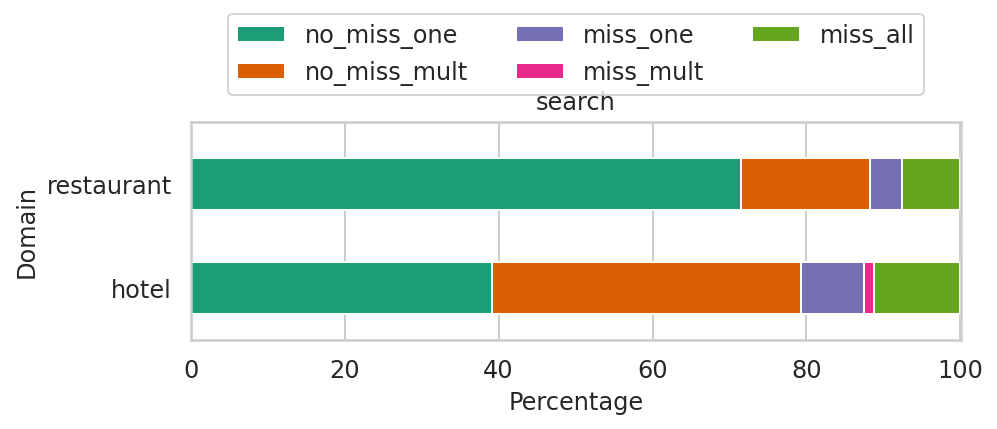

In [43]:
constr_type = 'search'
model = 'baseline'
data = expression_patterns_perc[model][constr_type]
plot_format['colors'] = sns.color_palette("Dark2", n_colors=len(data.keys()))
plot_format['title'] = {'label':  f'{constr_type}'}
plot_format['title']['fontdict'] = {'fontsize': 'medium'}
plot_format['stack_order'] = sorted(list(data.keys()), reverse=True)
ax, fig = plot_stacked_bar(
    data, plot_format
)
plt.tight_layout()

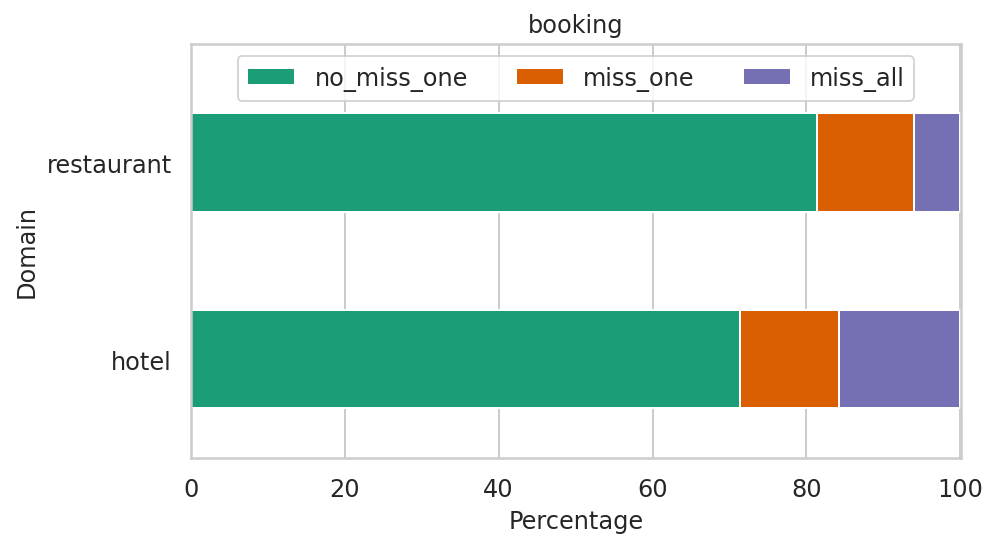

In [44]:
constr_type = 'booking'
model = 'baseline'
plot_format['legend'].pop('bbox_to_anchor', None)
data = expression_patterns_perc[model][constr_type]
plot_format['colors'] = sns.color_palette("Dark2", n_colors=len(data.keys()))
plot_format['title'] = {'label':  f'{constr_type}'}
plot_format['title']['fontdict'] = {'fontsize': 'medium'}
plot_format['stack_order'] = sorted(list(data.keys()), reverse=True)
ax, fig = plot_stacked_bar(
    data, plot_format
)
plt.tight_layout()